In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
class callbacka(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            print("\nLoss is low stopping trainng")
            self.model.stop_training=True

In [3]:
mcallbacks=callbacka()

In [6]:
base_dir='F:\chest_xray'
local_weight_file='VGG16_notop.h5'
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
sample_image_pneumonia=os.listdir(os.path.join(train_dir,'PNEUMONIA'))
sample_image_healthy=os.listdir(os.path.join(train_dir,'NORMAL'))

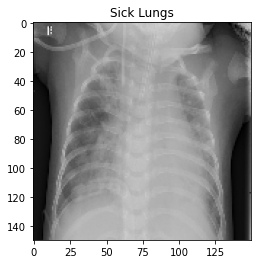

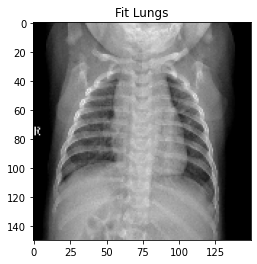

In [7]:
sample_image_pnue=sample_image_pneumonia[randint(0,(len(sample_image_pneumonia)-1))]
sample_image_normal=sample_image_healthy[randint(0,(len(sample_image_healthy)-1))]

img_to_array_sick=cv2.imread(os.path.join(os.path.join(train_dir,'PNEUMONIA'),sample_image_pnue))
img_to_array_fit=cv2.imread(os.path.join(os.path.join(train_dir,'NORMAL'),sample_image_normal))

plt.imshow(cv2.resize(img_to_array_sick,(150,150)))
plt.title("Sick Lungs")
plt.show()

plt.imshow(cv2.resize(img_to_array_fit,(150,150)))
plt.title("Fit Lungs")
plt.show()

In [8]:
pre_trained_model=VGG16(input_shape=(100,100,3),include_top=False,weights=None)
pre_trained_model.load_weights(local_weight_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [9]:
last_layer=pre_trained_model
last_output=last_layer.output
x=layers.Flatten()(last_output)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dropout(0.3)(x)
x=layers.Dense(1,activation='sigmoid')(x)

model=Model(pre_trained_model.input,x)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   samplewise_center=True,samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(rescale = 1./255,samplewise_center=True,samplewise_std_normalization=True)
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=20,class_mode='binary',target_size=(100,100))

Found 2682 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


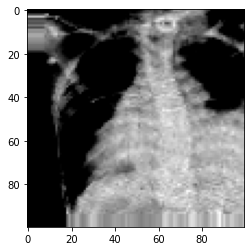

In [11]:
batch=train_generator.next()
data_sample=batch[0]
train_datagen.fit(data_sample)
x,y=train_generator.__getitem__(1)
plt.imshow(x[1])

In [12]:
validation_generator=test_datagen.flow_from_directory(test_dir,batch_size=10,class_mode='binary',target_size=(100,100))

Found 624 images belonging to 2 classes.


In [13]:
history=model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=134,epochs=20,validation_steps=60,verbose=2)

Epoch 1/20
134/134 - 259s - loss: 0.3222 - accuracy: 0.8753 - val_loss: 0.3256 - val_accuracy: 0.8933
Epoch 2/20
134/134 - 228s - loss: 0.1949 - accuracy: 0.9249 - val_loss: 0.3861 - val_accuracy: 0.8567
Epoch 3/20
134/134 - 235s - loss: 0.1806 - accuracy: 0.9275 - val_loss: 0.7396 - val_accuracy: 0.7700
Epoch 4/20
134/134 - 236s - loss: 0.1837 - accuracy: 0.9305 - val_loss: 0.3804 - val_accuracy: 0.8733
Epoch 5/20
134/134 - 235s - loss: 0.1552 - accuracy: 0.9410 - val_loss: 0.3706 - val_accuracy: 0.8683
Epoch 6/20
134/134 - 232s - loss: 0.1519 - accuracy: 0.9444 - val_loss: 0.3462 - val_accuracy: 0.8667
Epoch 7/20
134/134 - 241s - loss: 0.1391 - accuracy: 0.9470 - val_loss: 0.3488 - val_accuracy: 0.8733
Epoch 8/20
134/134 - 263s - loss: 0.1567 - accuracy: 0.9497 - val_loss: 0.3146 - val_accuracy: 0.9017
Epoch 9/20
134/134 - 336s - loss: 0.1432 - accuracy: 0.9440 - val_loss: 0.2968 - val_accuracy: 0.8850
Epoch 10/20
134/134 - 334s - loss: 0.1449 - accuracy: 0.9485 - val_loss: 0.2741 - 

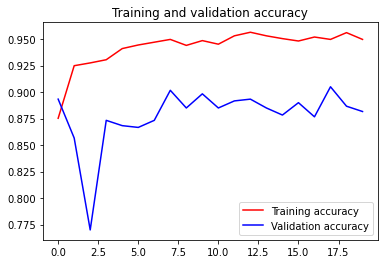

<Figure size 432x288 with 0 Axes>

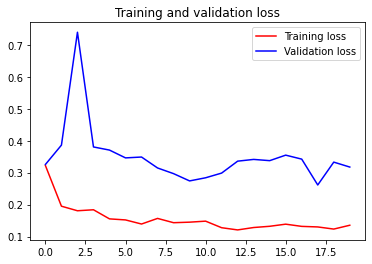

<Figure size 432x288 with 0 Axes>

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs,loss, 'r', label="Training loss")
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()